In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import dowhy

In [30]:
dataset = pd.read_csv("data.csv")
dataset.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [31]:
dataset['alcohol'] = dataset['Dalc']+dataset['Walc']
dataset['grades'] = dataset['G1']+dataset['G2']+dataset['G3']
dataset = dataset.drop(['G1','G2','G3'],axis=1)
dataset = dataset.drop(['Dalc','Walc'],axis=1)
dataset = dataset.drop(['sex','paid','Pstatus','nursery','schoolsup','address','internet','famsize','famsup','romantic','activities'],axis=1)
dataset.head()

,school,age,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,higher,famrel,freetime,goout,health,absences,grades,alcohol
0,GP,18,4,4,at_home,teacher,course,mother,2,2,0,yes,4,3,4,3,6,17,2
1,GP,17,1,1,at_home,other,course,father,1,2,0,yes,5,3,3,3,4,16,2
2,GP,15,1,1,at_home,other,other,mother,1,2,3,yes,4,3,2,3,10,25,5
3,GP,15,4,2,health,services,home,mother,1,3,0,yes,3,2,2,5,2,44,2
4,GP,16,3,3,other,other,home,father,1,2,0,yes,4,3,2,5,4,26,3


In [53]:
import pygraphviz
causal_graph = """digraph {

Medu[label="Mothor's Education"];
Fedu[label="Fathor's Education"];
Mjob[label="Mother's job"];
Fjob[label="Father's job"];
reason[label="Reason to Choose School"];
traveltime[label="Travel Time"];
studytime[label="Study Time"];
failures[label="Past Class Failures"];
higher[label="Want Higher Education"];
famrel[label="Family Relationships Quality"];
freetime[label="Free Time"];
goout[label="Go Out"];
U[label="Unobserved Confounders"];
school;
age;
guardian;
health;
absences;
alcohol;
grades;

U->{goout,absences,grades,failures};
reason->school;

Medu->Mjob;
Fedu->Fjob;
Medu->famrel;
Fedu->famrel;
Mjob->famrel;
Fjob->famrel;
famrel->grades;
famrel->guardian;
alcohol->health;

freetime->studytime;
freetime->traveltime;
freetime->goout;
studytime->grades;
higher->grades;
school->grades;
health->grades;
absences->grades;
}"""


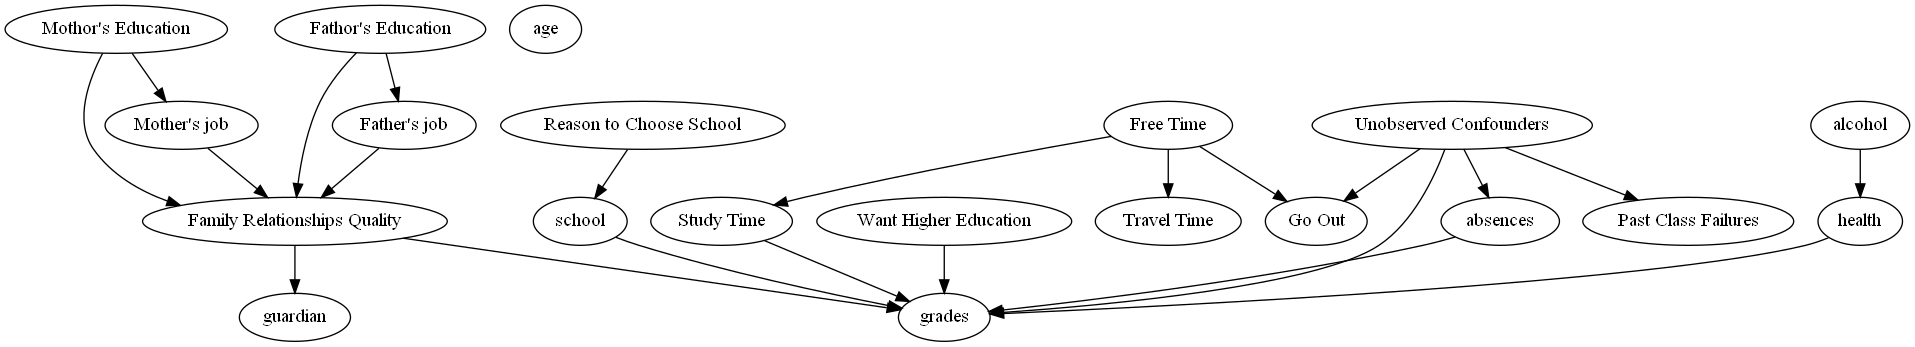

In [54]:
model= dowhy.CausalModel(
        data = dataset,
        graph=causal_graph.replace("\n", " "),
        treatment='reason',
        outcome='grades')
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [46]:
import statsmodels
model= dowhy.CausalModel(
        data = dataset,
        graph=causal_graph.replace("\n", " "),
        treatment="Medu",
        outcome='grades')
#Identify the causal effect
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                                          
───────(Expectation(grades|alcohol,studytime,age,Fjob,failures,reason,health,h
d[Medu]                                                                       

                                                      
igher,school,freetime,absences,traveltime,Fedu,goout))
                                                      
Estimand assumption 1, Unconfoundedness: If U→{Medu} and U→grades then P(grades|Medu,alcohol,studytime,age,Fjob,failures,reason,health,higher,school,freetime,absences,traveltime,Fedu,goout,U) = P(grades|Medu,alcohol,studytime,age,Fjob,failures,reason,health,higher,school,freetime,absences,traveltime,Fedu,goout)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
Estimand expression:
Expectation(Derivative(grades, [famrel])*Derivative([famrel], [M

In [12]:
estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.propensity_score_stratification",target_units="ate")
# ATE = Average Treatment Effect
# ATT = Average Treatment Effect on Treated (i.e. those who were assigned a different room)
# ATC = Average Treatment Effect on Control (i.e. those who were not assigned a different room)
print(estimate)

KeyError: 'grades'